In [1]:
# Install packages
import sys
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install catboost

You should consider upgrading via the '/Users/magnus/repos/TDT05-classification-project/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/magnus/repos/TDT05-classification-project/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/magnus/repos/TDT05-classification-project/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
# Imports
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, metrics

RANDOM_SEED = 42  # For reproducibility

In [3]:
# Loading the data
training_data = pd.read_csv('../input/tdt05-2021-challenge-2/challenge2_train.csv', index_col=0)
X_test = pd.read_csv('../input/tdt05-2021-challenge-2/challenge2_test.csv', index_col=0)
training_data

,target,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28
id,,,,,,,,,,,,,,,,,,,,,
0,0,1.0,gL,e,3.0,A,NaN,0.0,6.0,96ae67d3e,...,0.5,0.0,3.0,R,328b0cf4e,0.834041,T,N,1.0,14.2364
1,0,0.0,Rj,c,1.0,A,7.0,1.0,4.0,9fcf422f2,...,0.4,0.0,1.0,NaN,328b0cf4e,0.686021,T,N,1.0,NaN
2,0,NaN,In,a,1.0,A,10.0,1.0,6.0,a5adff44e,...,0.5,1.0,3.0,G,0c67fcbbd,1.141271,T,N,3.0,NaN
3,1,1.0,rA,c,3.0,A,7.0,1.0,1.0,15c90ab2e,...,0.6,1.0,1.0,G,fee4e3007,0.662382,T,N,3.0,NaN
4,0,1.0,pE,c,3.0,A,7.0,0.0,6.0,b36490559,...,0.5,0.0,1.0,B,587e040bd,-1.000000,T,N,1.0,13.9537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,1,0.0,tT,d,3.0,NaN,11.0,0.0,1.0,4fcf21245,...,0.6,1.0,1.0,R,72ccba7a4,0.890576,T,N,3.0,14.0466
49996,0,1.0,pB,b,2.0,A,7.0,0.0,6.0,8f926e828,...,0.1,0.0,7.0,R,250eea49d,NaN,T,N,1.0,14.0157
49997,0,0.0,TL,e,1.0,A,11.0,0.0,6.0,474e5d6c8,...,NaN,0.0,7.0,G,110d4786e,1.327592,T,N,1.0,13.9255


In [4]:
# Outlier removal by interquartile range (IQR) method
interval_features = ['f11', 'f17', 'f24', 'f28']
Q1 = training_data[interval_features].quantile(0.25)
Q3 = training_data[interval_features].quantile(0.75)
IQR = Q3 - Q1

initial_row_count = training_data.shape[0]

training_data = training_data[~(training_data > (Q3 + 1.5 * IQR)).any(axis=1)]

rows_removed = initial_row_count - training_data.shape[0]
print(f'Rows removed: {rows_removed}')

Rows removed: 2703


/var/folders/x0/3_dctplx2qz9mcytvtkt1d4m0000gn/T/ipykernel_31588/1647017917.py:9: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  training_data = training_data[~(training_data > (Q3 + 1.5 * IQR)).any(axis=1)]


In [5]:
# Imputing
fill_value = -999 

training_data = training_data.fillna(fill_value)
X_test = X_test.fillna(fill_value)

In [6]:
# Convert numerical features to categorical
categorical_numerical_features = ['f0', 'f6', 'f20']

training_data[categorical_numerical_features] = training_data[categorical_numerical_features].astype(str)
X_test[categorical_numerical_features] = X_test[categorical_numerical_features].astype(str)

In [7]:
# Feature dropping
dropped_features = []
initial_column_count = training_data.shape[1]

training_data.drop(dropped_features, axis=1, inplace=True)
X_test.drop(dropped_features, axis=1, inplace=True)

columns_removed = initial_column_count - training_data.shape[1]
print(f'Columns removed: {columns_removed}')

Columns removed: 0


In [8]:
# Partition the data
X = training_data.drop(columns=['target']).copy()
y = training_data[['target']].copy()

In [9]:
# Training
categorical_feature_indices_after_dropping = [0, 1, 2, 4, 6, 8, 9, 10, 12, 13, 14, 15, 18, 20, 22, 23, 25, 26]

catboost_model = CatBoostClassifier(
    custom_loss=[metrics.Accuracy()],
    random_seed=RANDOM_SEED,
    logging_level='Silent'
)

print('Training started...')

catboost_model.fit(
    X, y,
    cat_features=categorical_feature_indices_after_dropping
)

print('Training completed.')

Training started...


In [10]:
# Prediction
y_pred = catboost_model.predict(X_test, prediction_type='Probability')
predictions = pd.DataFrame({'id': X_test.index, 'target': y_pred[:,1]})

path = '../output/catboost.txt'
predictions.to_csv(path, index=False)
print(f'Saved results to file with path {path}.')

Saved results to file with path ../output/catboost.txt.


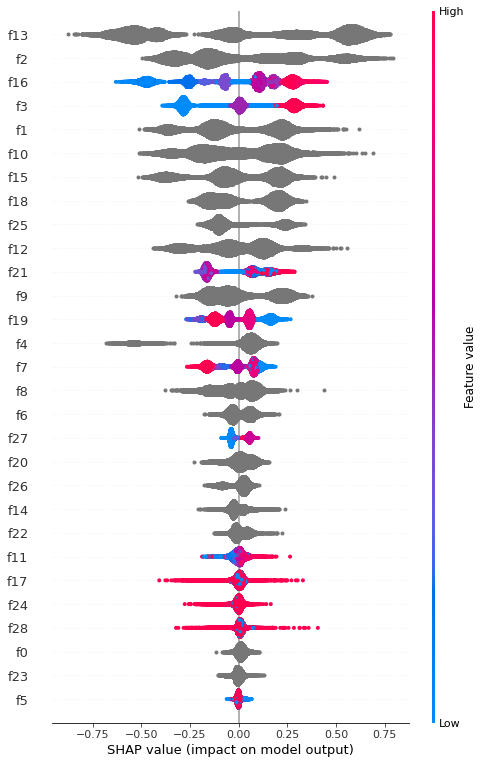

In [12]:
import shap
sorted_feature_importance = catboost_model.get_feature_importance()
explainer = shap.TreeExplainer(catboost_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, max_display=X_test.shape[1])